<a href="https://colab.research.google.com/github/johannpeterson/nijhawanlab/blob/master/amplicon_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook automates the analysis of high-throughput sequencing files from expermiments which submit a batch of combined samples for amplicon sequencing.

The following files are required:
1. Paired-read FASTQ files, e.g. `XXX_R1_001.fastq.gz` & `XXX_R2_001.fastq.gz`
1. Samples table, e.g. `XXX_samples.tsv`.  Discussed under **Samples Table**.
1. `primers.txt`.  This is a tab-delimited table of primers with 4 columns:
  1. `OriginalSeq` - the primer label
  1. `sequence` - the full sequence of the primer
  1. `barcode` - the primer "barcode"
  1. `direction` - the primer direction, either F or R

`XXX` above designates the particular experiment, and is specified in the [`experiment`](#scrollTo=qxgM5A3cSOqV) variable below.

Current version as of 11 September 2022.  Duplicate for each analysis.

# Preliminaries

## Experiment-Specific Variables
The following cells should contain all the variables you need to change in order to run this analysis with different data files.  The variable `experiment` below is used to set the working directory and the file names for the FASTQ files and the table of samples.

The `label_prefix` variable specifies the prefix in the primer labels.

In [1]:
experiment = "VK004"
label_prefix = "oVK"

In [2]:
base_directory = "/content/drive/My Drive/nijhawanlab/amplicons/"
data_directory = base_directory + experiment + "/"
source_directory = base_directory + "source/"
R1_file = data_directory + experiment + "_R1_001.fastq.gz"
R2_file = data_directory + experiment + "_R2_001.fastq.gz"
primer_file = data_directory + "primers.txt"
samples_file = data_directory + experiment + "_samples.tsv"

In [29]:
debug_mode = False

In [3]:
maximum_reads_per_file = 10**6

In [4]:
minimum_read_quality = 20
minimum_barcode_length = 14
maximum_barcode_length = 30

In [5]:
# TTCTTGACGAGTTCTTCTGA
reference_sequence_pre = 'TTCTTGACGAGTTCTTCTGA' 
# ACGCGTCTGGAACAATCAAC
reference_sequence_post = 'ACGCGTCTGGAACAATCAAC' 

reference_barcode_pattern = 'SWSWSWSWSWSWSWSWSWSW'
reference_barcode_regex_string = r"([GC][AT])+[GC]?"
primer_name_regex_string = r"(" + label_prefix + ")(\d{1,3})"
primer_name_regex_string

'(oVK)(\\d{1,3})'

## Mount the working directory & install modules:

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Google Colab does not have BioPython installed:

In [7]:
pip install Bio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.6/272.6 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.3 MB/s eta 0:00:00


In [ ]:
# pip install ipdb
# import ipdb

In [8]:
from Bio import Seq, SeqIO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import csv
import itertools
import re
from itertools import cycle
from tqdm import tqdm
from io import StringIO
import locale

## Utility functions


In [9]:
import sys
sys.path.insert(0, source_directory)

In [10]:
%load_ext autoreload
%cd "$source_directory"
# I don't understand why you need to change the working directory if you have added it to the path.
%aimport jpbio.util
%cd "$data_directory"

/content/drive/My Drive/nijhawanlab/amplicons/source
/content/drive/My Drive/nijhawanlab/amplicons/VK004


# Read Input Files

## Read in primers.txt and store primers in various useful forms

In [11]:
primers = []
with open(primer_file, newline='') as primers_IO:
    primer_reader = csv.DictReader(
        primers_IO, 
        delimiter='\t', 
        fieldnames=['OriginalSeq','sequence','barcode','direction'])
    for primer in primer_reader:
        primers.append(dict(primer))

forward_primers = [p['OriginalSeq'] for p in primers if p['direction']=='F']
reverse_primers = [p['OriginalSeq'] for p in primers if p['direction']=='R']

primer_lookup = {p['OriginalSeq']: 
                 {'len':len(p['sequence']), 
                  'sequence':p['sequence'],
                  'direction':p['direction']
                 } for p in primers}

primer_lookup

{'oVK025': {'len': 28,
  'sequence': 'GCTACCTTGGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK031': {'len': 28,
  'sequence': 'GCTGCCGAAGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK032': {'len': 28,
  'sequence': 'GCTACTGCTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK033': {'len': 28,
  'sequence': 'GCTGAACGTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK034': {'len': 28,
  'sequence': 'GCTATCCATGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK035': {'len': 28,
  'sequence': 'GCCTCCGGTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK036': {'len': 28,
  'sequence': 'GCTACCACCGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK037': {'len': 28,
  'sequence': 'GCTACCGAGGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK026': {'len': 30,
  'sequence': 'TTTTGTCACCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oVK038': {'len': 30,
  'sequence': 'TTTGTTAATCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oVK039': {'len': 30,
  'sequence': 'TTTTATGGTCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oV

## Primer ID

The `IdPrimers` function finds the primers matching a sequence.  For each primer, it searches starting at the first position in the read sequence for the primer sequence, and starting at the last positiom for the reverse compliment of the primer sequence.  Becuase of the loop, it will return the last matching primer in each direction, and makes no attempt to deal with sequences matching multiple primers.

In [12]:
def IdPrimers(seq):
    found_primers = {
        'fwd_primer':None,
        'fwd_primer_loc':None, 
        'rc_primer':None, 
        'rc_primer_loc':None, 
        'fwd_direction':None,
        'rc_direction':None
    }
    for p in primers:
        p1 = seq.find(p['sequence'])
        if p1 != -1:
            found_primers['fwd_primer'] = p['OriginalSeq']
            found_primers['fwd_primer_loc'] = p1
            found_primers['fwd_direction'] = p['direction']
        p2 = seq.rfind( jpbio.util.rcDNA( p['sequence'] ))
        if p2 != -1:
            found_primers['rc_primer'] = p['OriginalSeq']
            found_primers['rc_primer_loc'] = p2
            found_primers['rc_direction'] = p['direction']
    return found_primers

## Sanity Checking

This cell defines a series of functions (named `sanity_...`), which operate on a `full_read` data structure as returned by the `analyzeReads` function.  Each `sanity_` function returns `True` or `False`, according as the read pair passes the particular quality check.  The `sanity_checks` structure is a list containing one dictionary for each `sanity_` function.  

In [13]:
def sanity_id_match(full_read):
    return full_read['F_id'] == full_read['R_id']

def sanity_primer_match(full_read):
    return (
        (full_read['F_forward_primer'] == full_read['R_rc_primer']) &
        (full_read['F_rc_primer'] == full_read['R_forward_primer'])
    )

def sanity_all_primers_found(full_read):
    return (
        (full_read['F_forward_primer'] != None) & 
        (full_read['F_rc_primer'] != None) &
        (full_read['R_forward_primer'] != None) & 
        (full_read['R_rc_primer'] != None)
    )

def sanity_barcodes_match(full_read):
    return (full_read['F_barcode'] == full_read['R_barcode'])

def sanity_barcodes_length(full_read):
    lF = len(full_read['F_barcode'])
    lR = len(full_read['R_barcode'])
    return (
        (lF <= maximum_barcode_length) &
        (lF >= minimum_barcode_length) &
        (lR <= maximum_barcode_length) &
        (lR >= minimum_barcode_length)
    )

sanity_barcode_regex = re.compile(reference_barcode_regex_string)
def sanity_barcode_pattern(full_read):
    if sanity_barcode_regex.fullmatch(full_read['R_barcode']):
        return True
    else:
        return False
    
def sanity_barcodes_quality(full_read):
    return (
        (min(full_read['F_quality']) >= minimum_read_quality) &
        (min(full_read['R_quality']) >= minimum_read_quality)
    )

sanity_checks = [
    {
        'id':'any',
        'label':'Any Check',
        'description':'Read pairs failing any sanity check.',
        'function':(lambda _: True)
    },
    {
        'id':'id_match',
        'label':'IDs Match',
        'description':'R1 & R2 read IDs match.',
        'function':sanity_id_match},
    {
        'id':'primer_match',
        'label':'Primers Match',
        'description':'Forward & reverse primers for R1 & R2 match.',
        'function':sanity_primer_match
    },
    {
        'id':'primers_found',
        'label':'Primers Found',
        'description':'Forward & reverse primers identified in both reads.',
        'function':sanity_all_primers_found
    },
    {
        'id':'barcodes_match',
        'label':'Barcodes Match',
        'description':'Barcodes from R1 & R2 reads match exactly.',
        'function':sanity_barcodes_match
    },
    {
        'id':'barcode_length',
        'label':'Barcode Length',
        'description':'Barcode lengths are within the required range.',
        'function':sanity_barcodes_length
    },
    {
        'id':'barcode_pattern',
        'label':'Barcode Pattern',
        'description':'The R1 barcode matches the specified pattern (SWSW...).',
        'function':sanity_barcode_pattern
    },
    {
        'id':'barcodes_quality',
        'label':'Barcode Read Quality',
        'description':'The minimum read quality (PHRED score) for both barcodes is at least the minumum specified.',
        'function':sanity_barcodes_quality
    }
]

## Analyze Read
Identify the direction of the reads, forward & reverse primers, barcode location & sequence.  The `analyzeReads` function returns a dictionary structure with elements for the read IDs, forward and reverse compliment primers for each read, locations in the reads for the barcodes, the barcode sequences and the sequences of quality scores corresponding to the barcodes.

In [14]:
def analyzeReads(F_read, R_read, F_primers, R_primers):
    r = {}
    r['F_id'] = F_read.id
    r['R_id'] = R_read.id
    r['F_forward_primer'] = F_primers['fwd_primer']
    r['F_rc_primer'] = F_primers['rc_primer']
    r['R_forward_primer'] = R_primers['fwd_primer']
    r['R_rc_primer'] = R_primers['rc_primer']

    r['F_pre_loc'] = F_read.seq.find(reference_sequence_pre)
    r['F_post_loc'] = F_read.seq.find(reference_sequence_post)
    r['R_pre_loc'] = R_read.seq.find( jpbio.util.rcDNA(reference_sequence_pre) ) 
    r['R_post_loc'] = R_read.seq.find( jpbio.util.rcDNA(reference_sequence_post) ) 
    r['F_barcode_loc'] = [r['F_pre_loc']+len(reference_sequence_pre), r['F_post_loc']]
    r['R_barcode_loc'] = [r['R_post_loc']+len(reference_sequence_post), r['R_pre_loc']]
    r['F_barcode'] = str(F_read.seq)[ r['F_barcode_loc'][0] : r['F_barcode_loc'][1]]
    r['R_barcode'] = jpbio.util.rcDNA( str(R_read.seq)[ r['R_barcode_loc'][0] : r['R_barcode_loc'][1] ] )
    
    r['F_quality'] = F_read.letter_annotations["phred_quality"][ r['F_barcode_loc'][0] : r['F_barcode_loc'][1] ]
    r['R_quality'] = R_read.letter_annotations["phred_quality"][ r['R_barcode_loc'][0] : r['R_barcode_loc'][1] ]
    
    return r



This function (`analyzeReadsAndFillInPrimers`) is a modified version of the function above, to allow for pairs of reads that do not overlap enough to have both primers on each read in the pair.  It could use some fixing up, as it currently makes assumptions about the direction of the reads which work for the JK001 experiment but may not be valid in general.

In [26]:
def findBarcode(read):
  pre_loc = read.seq.find(reference_sequence_pre)
  post_loc = read.seq.find(reference_sequence_post)
  barcode_location = [pre_loc + len(reference_sequence_pre), post_loc]
  barcode = str(read.seq)[ barcode_location[0] : barcode_location[1] ]
  if (pre_loc == -1 | post_loc == -1):
    pre_loc = read.seq.find( jpbio.util.rcDNA(reference_sequence_pre) )
    post_loc = read.seq.find( jpbio.util.rcDNA(reference_sequence_post) )
    barcode_location = [post_loc + len(reference_sequence_post), pre_loc]
    barcode = jpbio.util.rcDNA(
        str(read.seq)[ barcode_location[0] : barcode_location[1] ]
    )
  barcodeQuality = read.letter_annotations["phred_quality"][ 
      barcode_location[0] : barcode_location[1]  
      ]
  return barcode, barcodeQuality

In [27]:
def analyzeReadsAndFillInPrimers(F_read, R_read, F_primers, R_primers):
    r = {}
    r['F_id'] = F_read.id
    r['R_id'] = R_read.id
    r['F_forward_primer'] = F_primers['fwd_primer']
    r['F_rc_primer'] = R_primers['fwd_primer']
    r['R_forward_primer'] = R_primers['fwd_primer']
    r['R_rc_primer'] = F_primers['fwd_primer']

    r['F_pre_loc'] = F_read.seq.find( jpbio.util.rcDNA(reference_sequence_pre) )
    r['F_post_loc'] = F_read.seq.find( jpbio.util.rcDNA(reference_sequence_post) )
    r['R_pre_loc'] = R_read.seq.find(reference_sequence_pre) 
    r['R_post_loc'] = R_read.seq.find(reference_sequence_post)
    if ( r['F_pre_loc'] == -1 | r['F_post_loc'] == -1 | r['R_pre_loc'] == -1 | r['R_post_loc'] == -1):
      if debug_mode: print("F primer not RC")
      r['F_pre_loc'] = F_read.seq.find(reference_sequence_pre)
      r['F_post_loc'] = F_read.seq.find(reference_sequence_post)
      r['R_pre_loc'] = R_read.seq.find( jpbio.util.rcDNA(reference_sequence_pre) ) 
      r['R_post_loc'] = R_read.seq.find( jpbio.util.rcDNA(reference_sequence_post) ) 

    r['F_barcode_loc'] = [r['F_post_loc']+len(reference_sequence_post), r['F_pre_loc']]
    r['R_barcode_loc'] = [r['R_pre_loc']+len(reference_sequence_pre), r['R_post_loc']]
    r['F_barcode'] = jpbio.util.rcDNA( str(F_read.seq)[ r['F_barcode_loc'][0] : r['F_barcode_loc'][1]] )
    r['R_barcode'] = str(R_read.seq)[ r['R_barcode_loc'][0] : r['R_barcode_loc'][1] ]

    r['F_barcode'], r['F_quality'] = findBarcode(F_read)
    r['R_barcode'], r['R_quality'] = findBarcode(R_read)

    # if debug_mode:
    #  ipdb.set_trace()

    if debug_mode:
      print(r)

    # print(r['F_barcode'])
    # print(r['R_barcode'])

    # print(F_read.seq)
    # print(R_read.seq)
    
    # r['F_quality'] = F_read.letter_annotations["phred_quality"][ r['F_barcode_loc'][0] : r['F_barcode_loc'][1] ]
    # r['R_quality'] = R_read.letter_annotations["phred_quality"][ r['R_barcode_loc'][0] : r['R_barcode_loc'][1] ]
    
    return r

## Figure out how many sequences are in each file

This runs separate processes to decompress and count lines in the input fastq files.  If it takes too much time, it can be skipped, but it doesn't take very long compared with processing the files below.  The advantage of running it is that the progress bar during processing accurately reflects how many sequences there are.

If [`maximum_reads_per_file`](#scrollTo=EhIRApjv_PzZ) is set to a smaller number than the number of reads in the FASTQ files, then only read that many pairs.

In [16]:
R1_lines = !cat "$R1_file" | gunzip | wc -l
R2_lines = !cat "$R2_file" | gunzip | wc -l

In [17]:
import math
maximum_reads_per_file = min(
    maximum_reads_per_file,
    int(math.ceil( max( int(R1_lines[0])/4, int(R2_lines[0])/4) ))
)

## Load paired reads from FASTQ files
This is the code that loops through the paired read FASTQ files.  It is the most time-consuming part of the process.  (It runs at about 1500 sequence pairs per second, so about 11 minutes to process 1 million paired reads.)

In [ ]:
with gzip.open(R1_file, "rt") as R1, gzip.open(R2_file, "rt") as R2:
  reads1 = SeqIO.parse(R1, "fastq")
  reads2 = SeqIO.parse(R2, "fastq")
  maxReads = maximum_reads_per_file
  readNumber = 1
  reads_list = []
  quality_statistics = {
    "R1": {
      "read_counts":[], 
      "N_counts":[],
      "phred_scores":[],
      "read_lengths":[]
      }, 
    "R2": {
      "read_counts":[], 
      "N_counts":[],
      "phred_scores":[],
      "read_lengths":[]
      }
    }
  sanity_failures = {i['id']:0 for i in sanity_checks}
        
  progress_bar = tqdm(total=maxReads)
  for (read1, read2) in zip(reads1, reads2):
    R1_sequence = str(read1.seq)
    R2_sequence = str(read2.seq)

    # identify the primers and analyze the read pair
    R1_primers = IdPrimers(R1_sequence)
    R2_primers = IdPrimers(R2_sequence)
    if R1_primers['fwd_direction'] == 'F':
      full_read = analyzeReadsAndFillInPrimers(read1, read2, R1_primers, R2_primers)
    else:
      full_read = analyzeReadsAndFillInPrimers(read2, read1, R2_primers, R1_primers)

    # quality checks on the read pair
    any_failure = False
    for check in sanity_checks:
      try:
          test_passes = check['function'](full_read)
      except ValueError:
          test_passes = False
      if not test_passes:
          sanity_failures[check['id']] += 1
          any_failure = True
    if any_failure:
      sanity_failures['any'] += 1
    else:
      reads_list.append(
          {'barcode':full_read['F_barcode'],
            'forward_primer':full_read['F_forward_primer'],
            'reverse_primer':full_read['F_rc_primer']
          }
      )

    # tabulate quality statistics
    R1_quality = read1.letter_annotations["phred_quality"]
    R2_quality = read2.letter_annotations["phred_quality"]
    R1_length = len(R1_sequence)
    R2_length = len(R2_sequence)
    quality_statistics["R1"]["read_counts"] = jpbio.util.pad_list(quality_statistics["R1"]["read_counts"], R1_length, 0)
    quality_statistics["R2"]["read_counts"] = jpbio.util.pad_list(quality_statistics["R2"]["read_counts"], R2_length, 0)
    quality_statistics["R1"]["N_counts"] = jpbio.util.pad_list(quality_statistics["R1"]["N_counts"], R1_length, 0)
    quality_statistics["R2"]["N_counts"] = jpbio.util.pad_list(quality_statistics["R2"]["N_counts"], R2_length, 0)
    quality_statistics["R1"]["phred_scores"] = jpbio.util.pad_dict_list(quality_statistics["R1"]["phred_scores"], R1_length)
    quality_statistics["R2"]["phred_scores"] = jpbio.util.pad_dict_list(quality_statistics["R2"]["phred_scores"], R2_length)
    quality_statistics["R1"]["read_lengths"].append(R1_length)
    quality_statistics["R2"]["read_lengths"].append(R2_length)

    for i in range(R1_length):
      quality_statistics["R1"]["read_counts"][i] += 1
      if R1_sequence[i] == 'N':
          quality_statistics["R1"]["N_counts"][i] += 1
      q = R1_quality[i]
      if q in quality_statistics["R1"]["phred_scores"][i]:
          quality_statistics["R1"]["phred_scores"][i][ q ] += 1
      else:
          quality_statistics["R1"]["phred_scores"][i][ q ] = 1
                
    for i in range(R2_length):
      quality_statistics["R2"]["read_counts"][i] += 1
      if R2_sequence[i] == 'N':
          quality_statistics["R2"]["N_counts"][i] += 1
      q = R2_quality[i]
      if q in quality_statistics["R2"]["phred_scores"][i]:
          quality_statistics["R2"]["phred_scores"][i][ q ] += 1
      else:
          quality_statistics["R2"]["phred_scores"][i][ q ] = 1

    progress_bar.update(1)
    if readNumber == maxReads:
      break
    readNumber += 1

progress_bar.close()

#for i in sanity_failures:
#    sanity_failures[i['id']]['label'] = sanity_checks[i['id']]


`reads_list` is now a list of dictionaries, one for each read pair which passed the sanity checks.

In [31]:
reads_list[0:5]

[{'barcode': 'CTGTCTGTGTCTGTGTCTCTGAGA',
  'forward_primer': 'oVK032',
  'reverse_primer': 'oVK039'},
 {'barcode': 'CAGTCTCTCACAGAGTCACAGACT',
  'forward_primer': 'oVK025',
  'reverse_primer': 'oVK045'},
 {'barcode': 'GAGAGAGAGTCAGACACACAGTCA',
  'forward_primer': 'oVK025',
  'reverse_primer': 'oVK039'},
 {'barcode': 'CTGTGAGTCTGACTCACTCAGAGA',
  'forward_primer': 'oVK034',
  'reverse_primer': 'oVK047'},
 {'barcode': 'CACTCTGTGACTCAGAGAGTGTCA',
  'forward_primer': 'oVK025',
  'reverse_primer': 'oVK043'}]

In [32]:
barcodes = pd.DataFrame(
    reads_list
)

In [33]:
barcodes

,barcode,forward_primer,reverse_primer
0,CTGTCTGTGTCTGTGTCTCTGAGA,oVK032,oVK039
1,CAGTCTCTCACAGAGTCACAGACT,oVK025,oVK045
2,GAGAGAGAGTCAGACACACAGTCA,oVK025,oVK039
3,CTGTGAGTCTGACTCACTCAGAGA,oVK034,oVK047
4,CACTCTGTGACTCAGAGAGTGTCA,oVK025,oVK043
...,...,...,...
46383,CTGTGTCAGTGTCAGTCTGACACT,oVK025,oVK038
46384,GAGAGAGAGTCAGACACACAGTCA,oVK032,oVK039
46385,CACACTGACAGTGACAGTCTGTCT,oVK034,oVK026
46386,CTGTGTCAGTGTCAGTCTGACACT,oVK025,oVK046


# Quality Checking

## Barcode Length

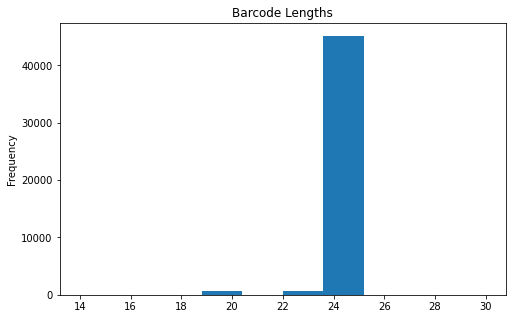

In [34]:
fig_barcode_lengths, axs_barcode_lengths = plt.subplots( figsize=(8,5) )
barcodes['barcode'].apply(len).plot.hist(title='Barcode Lengths', ax=axs_barcode_lengths)

In [ ]:
jpbio.util.export_figure(fig_barcode_lengths, "barcode_lengths", data_directory, experiment)

## Examine the read pairs failing sanity checks

In [35]:
sanity_checks_lookup = {i["id"]:i["label"] for i in sanity_checks} 
checks_data_frame = pd.DataFrame(
    [[i, sanity_failures[i], sanity_checks_lookup[i]] for i in sanity_failures],
    columns = ['id', 'count', 'label']
).sort_values('count', ascending=False)

In [36]:
checks_data_frame

,id,count,label
0,any,138774,Any Check
3,primers_found,95546,Primers Found
7,barcodes_quality,92503,Barcode Read Quality
4,barcodes_match,61428,Barcodes Match
6,barcode_pattern,57314,Barcode Pattern
5,barcode_length,47656,Barcode Length
1,id_match,0,IDs Match
2,primer_match,0,Primers Match


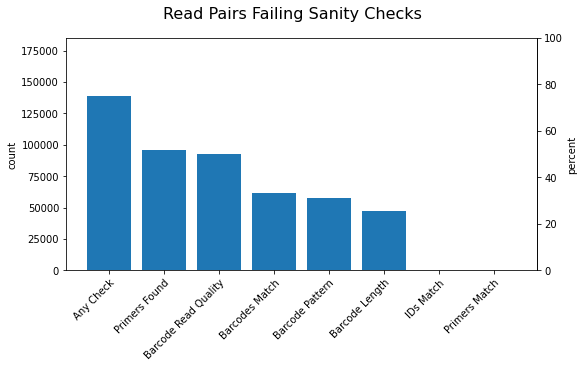

In [37]:
fig_sanity, ax_sanity = plt.subplots(constrained_layout=True, figsize=(8,5))
fig_sanity.suptitle('Read Pairs Failing Sanity Checks', fontsize=16)

ax_sanity.bar(data=checks_data_frame, height='count', x='label')

def n_to_percent(n):
    return 100*n/readNumber

def percent_to_n(p):
    return p*readNumber/100

secax = ax_sanity.secondary_yaxis('right', functions=(n_to_percent, percent_to_n))
secax.set_ylabel('percent')
ax_sanity.set_ylabel('count')
ax_sanity.set_ylim([0, readNumber])
plt.setp(ax_sanity.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

In [ ]:
jpbio.util.export_figure(fig_sanity, "sanity_checks", data_directory, experiment)

## Examine the Overall Read Quality

In [38]:
def SeqDiagnosticPlot(quality_statistics, maintitle="Read Quality"):

    def mean_from_dictionary_of_counts(d):
        M = 0
        T = 0
        for k in d:
            M += k*d[k]
            T += d[k]
        return M/T
    
    max_length = len(quality_statistics["read_counts"])
    positions = range(1, max_length + 1)
    max_qual_by_position = [max( [k for k in d] ) for d in quality_statistics["phred_scores"]]
    min_qual_by_position = [min( [k for k in d] ) for d in quality_statistics["phred_scores"]]
    mean_qual_by_position = [mean_from_dictionary_of_counts(d) for d in quality_statistics["phred_scores"]]
    max_N_count = max([10, max( quality_statistics["N_counts"] )])
    
    fig, (axis_quality, axis_N, axis_read_count) = plt.subplots(
        3,1,
        sharex='all',
        figsize=(15,7)
    )
    fig.suptitle(maintitle, fontsize=16)
    
    min_max_handle = axis_quality.fill_between(
        x=positions, 
        y1=min_qual_by_position, 
        y2=max_qual_by_position, 
        color="lightgrey", 
        label='range')
    mean_handle, = axis_quality.step(
        x=positions,
        y=mean_qual_by_position, 
        label='mean')
    axis_quality.legend(loc='lower center')
    axis_quality.set_xlabel('position')
    axis_quality.set_ylabel('quality')
    axis_quality.yaxis.grid(True)
    axis_quality.spines["bottom"].set_visible(True)
    axis_quality.spines["top"].set_visible(False)
    axis_quality.spines["left"].set_visible(True)
    axis_quality.spines["right"].set_visible(False)
    
    axis_read_count.set_yscale('log')
    axis_read_count.plot(quality_statistics["read_counts"], color='grey')
    axis_read_count.hist(quality_statistics["read_lengths"], range=(0,max_length), bins=25, color='lightblue')
    axis_read_count.set_ylabel('read count')
    axis_read_count.spines["bottom"].set_visible(True)
    axis_read_count.spines["top"].set_visible(False)
    axis_read_count.spines["left"].set_visible(True)
    axis_read_count.spines["right"].set_visible(False)
    
    axis_N.spines["bottom"].set_visible(True)
    axis_N.spines["top"].set_visible(False)
    axis_N.spines["left"].set_visible(True)
    axis_N.spines["right"].set_visible(False)
    axis_N.set_ylim([0, max_N_count])
    axis_N.step(x=positions, y=quality_statistics["N_counts"])
    axis_N.set_ylabel('N content')

    return fig

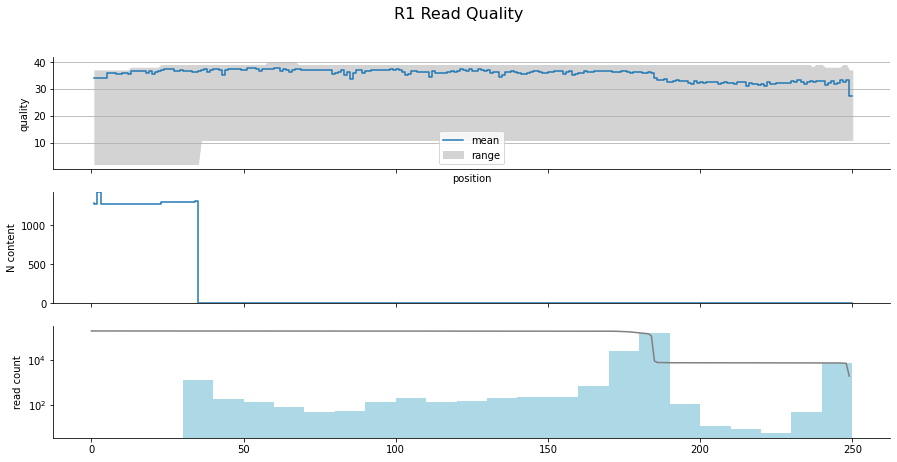

In [39]:
fig_R1 = SeqDiagnosticPlot(quality_statistics["R1"], maintitle="R1 Read Quality")

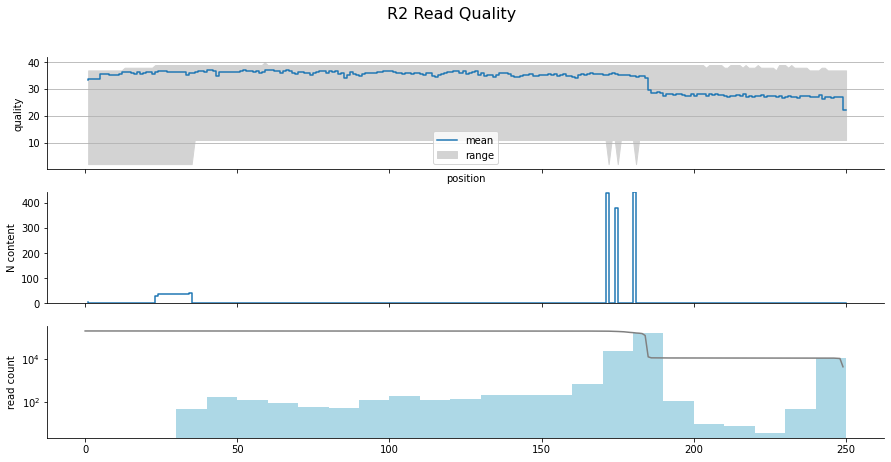

In [40]:
fig_R2 = SeqDiagnosticPlot(quality_statistics["R2"], maintitle="R2 Read Quality")

In [ ]:
jpbio.util.export_figure(fig_R1, "R1_quality", data_directory, experiment)
jpbio.util.export_figure(fig_R2, "R2_quality", data_directory, experiment)

# Samples Table

<a id='s1'></a>
The `samples.tsv` file should be a tab-separated table of the sample IDs, with row & column labels indicating the primers for that sample.  

Like this:

| | | | | | | | | | | | | | | |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|	| oNB176 | oNB194 | oNB195 | oNB196 | oNB197 | oNB198 | oNB199 | oNB200 | oNB201 | oNB202 | oNB203 | oNB204 |
oNB177 | 2281 | 2282 | 2283 | 2285 | 2286 | 2287 | 2293 | 2294 | 2301 | 2302 | 2306 | 2307 |
oNB205 | 2308 | 2315 | 2316 | 2317 | 2318 | 2331 | 2332 | 2333 | 2334 | 2351 | 2352 | 2353 |
oNB206 | 2354 | 2355 | 2356 | 2357 | 2358 | 2359 | 2360 | 2394 | 2398 | water | Hct116 | c9 |
oNB207 | | | | | | | | | | | | | | | |											
oNB208 | | | | | | | | | | | | | | | |							
oNB209 | | | | | | | | | | | | | | | |
oNB210 | | | | | | | | | | | | | | | |
oNB211 | | | | | | | | | | | | | | | |


In [41]:
with open(samples_file, 'r') as f:
    samples_table = f.read()
    print(samples_table)

	oVK026	oVK038	oVK039	oVK040	oVK041	oVK042	oVK043	oVK044	oVK045	oVK046	oVK047	oVK048
oVK025	805	806	807	808	809	810	811	812	813	814	815	816
oVK031	817	818	819	820	821	822	823	824	825	826	827	828
oVK032	829	830	831	832	833	834	852	853	854	855	856	857
oVK033	858	859	860	861	862	863	864	870	871	872	873	874
oVK034	935	876	877	245	289	431	221	751	724	water		
oVK035												
oVK036												
oVK037												


In [42]:
primer_name_regex = re.compile(primer_name_regex_string)

def pad_primer(s):
    m = primer_name_regex.match(s)
    if m is not None:
      return m.group(1) + m.group(2).rjust(3, '0')
    else:
      return None

with open(samples_file, "r") as f:
    csvraw = list(csv.reader(f, delimiter='\t'))
col_headers = [pad_primer(h) for h in csvraw[0][1:] ]
row_headers = [ pad_primer(row[0]) for row in csvraw[1:] ]
data = [row[1:] for row in csvraw[1:]]
sample_list = [s for sublist in data for s in sublist if s != '']
sample_dict = {row_headers[r]:{col_headers[c]:data[r][c] for c in range(len(col_headers))} for r in range(0, len(row_headers))}

In [43]:
sample_dict

{'oVK025': {'oVK026': '805',
  'oVK038': '806',
  'oVK039': '807',
  'oVK040': '808',
  'oVK041': '809',
  'oVK042': '810',
  'oVK043': '811',
  'oVK044': '812',
  'oVK045': '813',
  'oVK046': '814',
  'oVK047': '815',
  'oVK048': '816'},
 'oVK031': {'oVK026': '817',
  'oVK038': '818',
  'oVK039': '819',
  'oVK040': '820',
  'oVK041': '821',
  'oVK042': '822',
  'oVK043': '823',
  'oVK044': '824',
  'oVK045': '825',
  'oVK046': '826',
  'oVK047': '827',
  'oVK048': '828'},
 'oVK032': {'oVK026': '829',
  'oVK038': '830',
  'oVK039': '831',
  'oVK040': '832',
  'oVK041': '833',
  'oVK042': '834',
  'oVK043': '852',
  'oVK044': '853',
  'oVK045': '854',
  'oVK046': '855',
  'oVK047': '856',
  'oVK048': '857'},
 'oVK033': {'oVK026': '858',
  'oVK038': '859',
  'oVK039': '860',
  'oVK040': '861',
  'oVK041': '862',
  'oVK042': '863',
  'oVK043': '864',
  'oVK044': '870',
  'oVK045': '871',
  'oVK046': '872',
  'oVK047': '873',
  'oVK048': '874'},
 'oVK034': {'oVK026': '935',
  'oVK038': '87

In [44]:
barcodes['sample'] = barcodes.apply(
    lambda row: sample_dict[ row['forward_primer'] ][ row['reverse_primer'] ],
    axis=1
)

In [45]:
barcodes

,barcode,forward_primer,reverse_primer,sample
0,CTGTCTGTGTCTGTGTCTCTGAGA,oVK032,oVK039,831
1,CAGTCTCTCACAGAGTCACAGACT,oVK025,oVK045,813
2,GAGAGAGAGTCAGACACACAGTCA,oVK025,oVK039,807
3,CTGTGAGTCTGACTCACTCAGAGA,oVK034,oVK047,
4,CACTCTGTGACTCAGAGAGTGTCA,oVK025,oVK043,811
...,...,...,...,...
46383,CTGTGTCAGTGTCAGTCTGACACT,oVK025,oVK038,806
46384,GAGAGAGAGTCAGACACACAGTCA,oVK032,oVK039,831
46385,CACACTGACAGTGACAGTCTGTCT,oVK034,oVK026,935
46386,CTGTGTCAGTGTCAGTCTGACACT,oVK025,oVK046,814


## Read Count per Sample

In [46]:
counts_by_sample = barcodes.groupby(by='sample').size().reset_index(name='count').sort_values(['count'], ascending=[False])

In [47]:
counts_by_sample

,sample,count
9,807,1509
45,860,1361
56,877,1328
33,831,1185
32,830,1167
43,858,1163
44,859,1156
15,813,1117
31,829,1111
13,811,1073


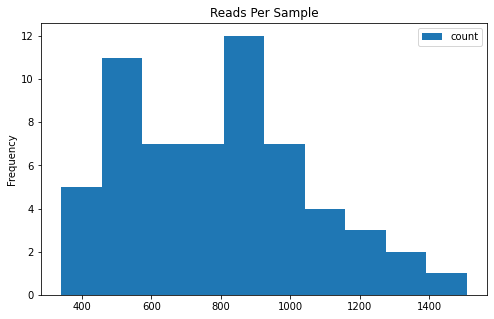

In [48]:
fig_counts_by_sample, axs_counts_by_sample = plt.subplots( figsize=(8,5) )
counts_by_sample.plot.hist(title='Reads Per Sample', ax=axs_counts_by_sample)

In [ ]:
jpbio.util.export_figure(fig_counts_by_sample, "counts_by_sample", data_directory, experiment)

# Analysis By Sample

## Top 10 Reads per Sample

In [49]:
counts_table = barcodes.groupby(by=["forward_primer","reverse_primer","sample","barcode"]).size().reset_index(name="count").sort_values(['forward_primer','reverse_primer','count'], ascending=[True,True,False])
counts_table.columns=["forward_primer","reverse_primer","sample","barcode","count"]
counts_table

,forward_primer,reverse_primer,sample,barcode,count
5,oVK025,oVK026,805,CAGTCTCTCACAGAGTCACAGACT,241
2,oVK025,oVK026,805,CACTCTGTGACTCAGAGAGTGTCA,101
0,oVK025,oVK026,805,CACACTGACAGTGACAGTCTGTCT,56
15,oVK025,oVK026,805,CTGTGTCAGTGTCAGTCTGACACT,37
6,oVK025,oVK026,805,CTCACTCTGTGACTGAGAGAGACA,36
...,...,...,...,...,...
2251,oVK034,oVK048,,GTCACACTGACACACTGTCTCTGT,1
2252,oVK034,oVK048,,GTCACAGTCAGACAGTCAGACTCA,1
2256,oVK034,oVK048,,GTCTGTGTGAGTGTGTGAGACACA,1
2261,oVK034,oVK048,,GTGTCTGAGACAGAGACTGTCAGT,1


In [50]:
len( counts_table['barcode'].unique() )

204

In [51]:
top_10_counts_table = counts_table.groupby(by=["forward_primer","reverse_primer"]).nth(list(range(10))).reset_index()

In [52]:
top_10_counts_table

,forward_primer,reverse_primer,sample,barcode,count
0,oVK025,oVK026,805,CAGTCTCTCACAGAGTCACAGACT,241
1,oVK025,oVK026,805,CACTCTGTGACTCAGAGAGTGTCA,101
2,oVK025,oVK026,805,CACACTGACAGTGACAGTCTGTCT,56
3,oVK025,oVK026,805,CTGTGTCAGTGTCAGTCTGACACT,37
4,oVK025,oVK026,805,CTCACTCTGTGACTGAGAGAGACA,36
...,...,...,...,...,...
595,oVK034,oVK048,,CACACTGACAGTGACAGTCTGTCT,22
596,oVK034,oVK048,,GACACTCACACTGACAGACACACT,22
597,oVK034,oVK048,,GTGACTGTGAGTCTCAGTGACAGT,19
598,oVK034,oVK048,,GTCTGTCTCAGTCACACACAGTGT,18


In [53]:
top_10_counts_table.to_excel(
    experiment + "_top_10_reads.xlsx",
    sheet_name = "Top 10 Reads"
)

## Water Control

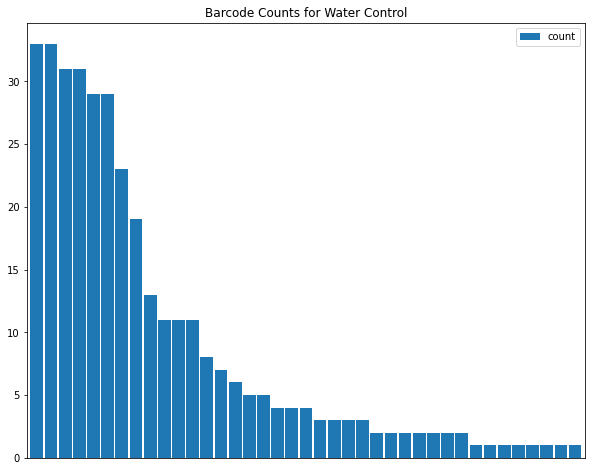

In [54]:
fig_water_counts, axs_water_counts = plt.subplots( figsize=(8,5) )

counts_table[counts_table['sample']=='water'].sort_values(
    "count", 
    ascending=False
).plot.bar(
    y="count", 
    xticks=[], 
    figsize=(10,8),
    title='Barcode Counts for Water Control',
    ax=axs_water_counts,
    width=0.9
)

`water_count` is the maximum number of reads for a single barcode found in the water control sample.

In [55]:
water_count = max(counts_table[ counts_table['sample'] == 'water' ]['count'])
water_count

33

Filter the table of barcode counts by excluding all barcodes with a count less than the maximum count in the water control.

## Analyze Barcode Distribution by Sample

### Interactive Histogram by Sample ID

In [56]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [57]:
samples_list = list( counts_table['sample'].unique() )

In [58]:
@interact
def counts_for_sample(sample=samples_list):
    return counts_table[ counts_table['sample'] == sample ] \
        .head(10) \
        .reset_index(drop=True) \
        .style.bar(subset=['count'],color='lightblue') \
        .hide_index() \
        .hide_columns(['sample','forward_primer','reverse_primer'])

interactive(children=(Dropdown(description='sample', options=('805', '806', '807', '808', '809', '810', '811',…

### Grid of Barcode Counts for All Samples

In [59]:
counts_by_primers = barcodes.groupby(
    by=['forward_primer','reverse_primer','sample']) \
        .size() \
        .reset_index(name='count') \
        .sort_values(['count'], ascending=[False])
counts_by_primers

,forward_primer,reverse_primer,sample,count
2,oVK025,oVK039,807,1509
38,oVK033,oVK039,860,1361
50,oVK034,oVK039,877,1328
26,oVK032,oVK039,831,1185
25,oVK032,oVK038,830,1167
36,oVK033,oVK026,858,1163
37,oVK033,oVK038,859,1156
8,oVK025,oVK045,813,1117
24,oVK032,oVK026,829,1111
6,oVK025,oVK043,811,1073


Generating this figure is also relatively time-consuming (though not close to the main loop above).

Text(0.5, 0.98, 'VK004')

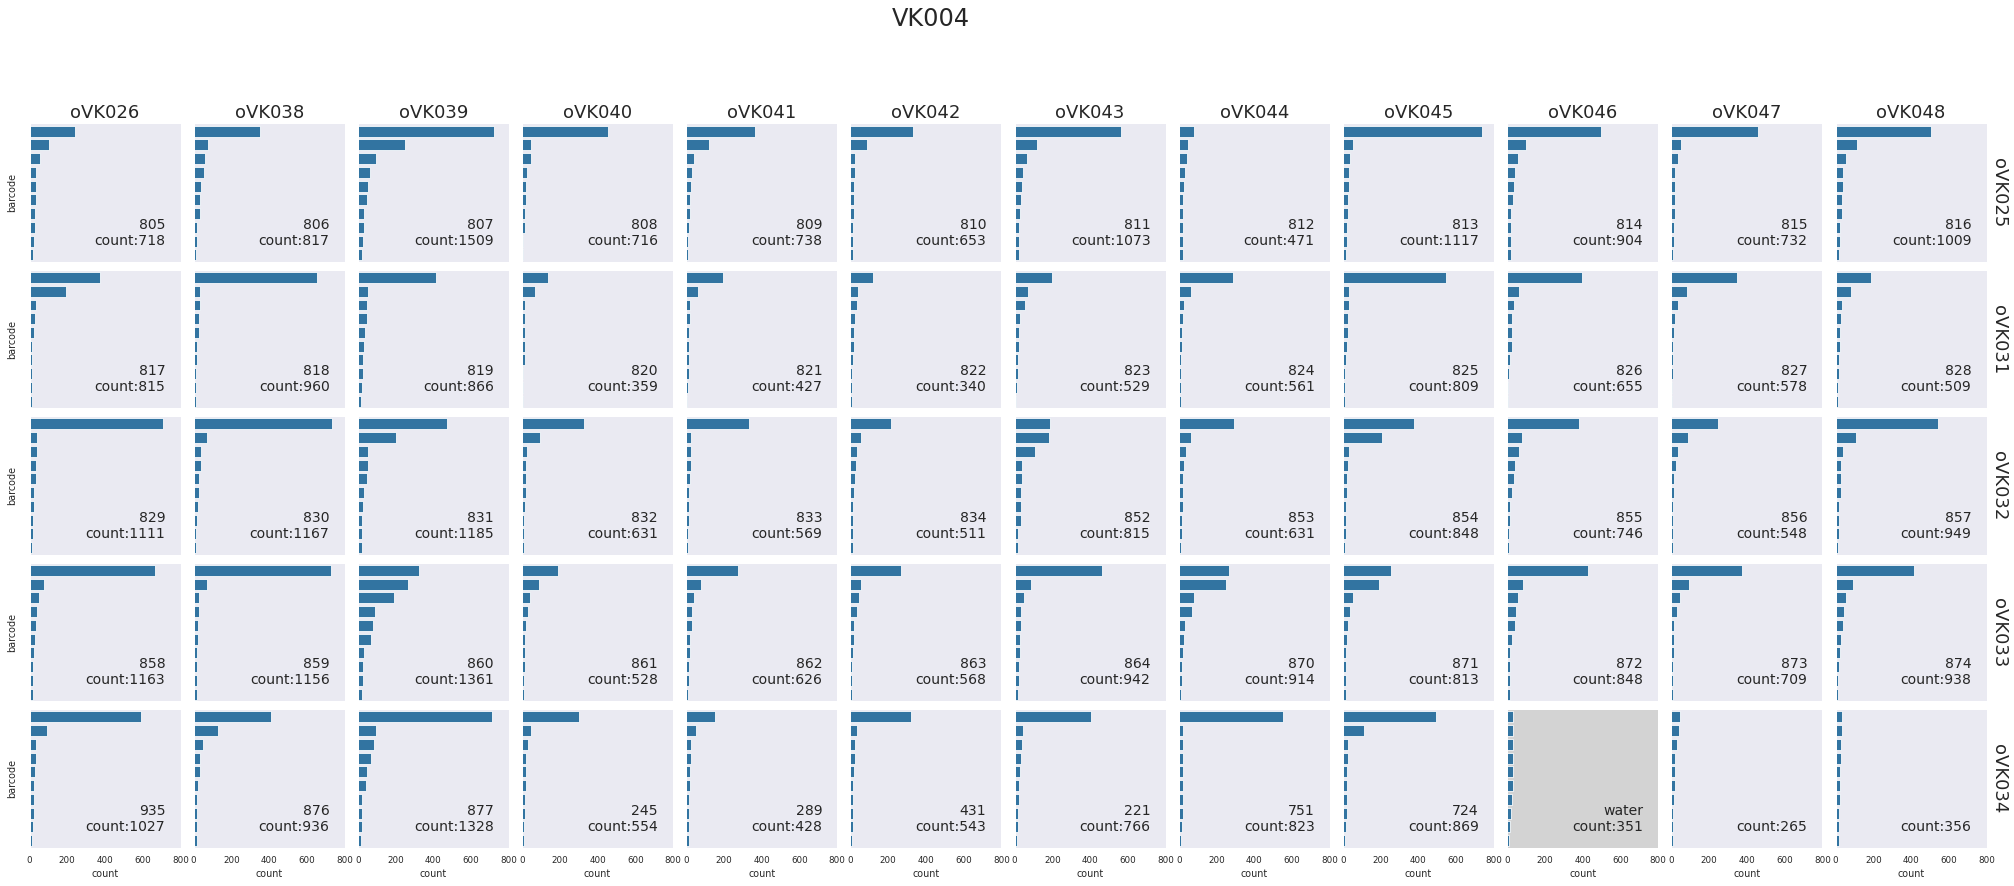

In [60]:
def annotate(data, **kws):
    f = data.iloc[0]['forward_primer']
    r = data.iloc[0]['reverse_primer']
    n = counts_by_primers[(counts_by_primers['forward_primer'] == f) & (counts_by_primers['reverse_primer'] == r)].iloc[0]['count']
    sample = sample_dict[f][r]
    ax = plt.gca()
    if sample == 'water':
        ax.set_facecolor('lightgrey')
        
    ax.text(.9, .1, f"{sample}\ncount:{n}", fontsize=14, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

sns.set_style()
sns.set_style("dark")
sns.set_context("paper")
hist_grid = sns.FacetGrid(top_10_counts_table, row="forward_primer", col="reverse_primer", height=2.5, aspect=1 ,margin_titles=True)
hist_grid.map_dataframe(
    sns.barplot, 
    x="count", 
    y="barcode",
    # order=counts_table['count'].value_counts().iloc[:5].index,
    orient='h')
hist_grid.map_dataframe(annotate)
hist_grid.set_yticklabels(None)
hist_grid.set_xticklabels(None)
hist_grid.set_titles(col_template="{col_name}", row_template="{row_name}", size=18)
plt.subplots_adjust(top=0.85)
hist_grid.fig.suptitle(experiment, fontsize=24)

In [ ]:
jpbio.util.export_figure(hist_grid, "histograms", data_directory, experiment)

In [61]:
counts_table[ counts_table['count'] > water_count ]

,forward_primer,reverse_primer,sample,barcode,count
5,oVK025,oVK026,805,CAGTCTCTCACAGAGTCACAGACT,241
2,oVK025,oVK026,805,CACTCTGTGACTCAGAGAGTGTCA,101
0,oVK025,oVK026,805,CACACTGACAGTGACAGTCTGTCT,56
15,oVK025,oVK026,805,CTGTGTCAGTGTCAGTCTGACACT,37
6,oVK025,oVK026,805,CTCACTCTGTGACTGAGAGAGACA,36
...,...,...,...,...,...
2107,oVK034,oVK044,751,GTCTGTCTCAGTCACACACAGTGT,550
2146,oVK034,oVK045,724,GTGACTGTGAGTCTCAGTGACAGT,494
2121,oVK034,oVK045,724,CAGTCTCTCACAGAGTCACAGACT,111
2196,oVK034,oVK047,,CAGTCTCTCACAGAGTCACAGACT,46


# Other Stuff - Do Not Run

The following cells are work in progress and have not been tested.  The goals are:
1. Find barcodes that appear in more than one sample, and determine which to filter out.
1. Look for an automated way to identify samples that have 1 or 2 dominant barcodes.

## Overlapping Barcodes

In [ ]:
fwd = "oVK025"
rev = "oVK038"
bc = counts_table[(counts_table['forward_primer']==fwd) & (counts_table['reverse_primer']==rev)].nlargest(1,"count")["barcode"].iloc[0]
bc

'GTGTGTGTGTGAGTGTGTGAGTGT'

In [ ]:
counts_table[counts_table['barcode'] == bc]

,forward_primer,reverse_primer,sample,barcode,count
130,oVK025,oVK026,1941,GTGTGTGTGTGAGTGTGTGAGTGT,70
278,oVK025,oVK038,1942,GTGTGTGTGTGAGTGTGTGAGTGT,2515
418,oVK025,oVK039,1943,GTGTGTGTGTGAGTGTGTGAGTGT,105
533,oVK025,oVK040,1944,GTGTGTGTGTGAGTGTGTGAGTGT,69
662,oVK025,oVK041,1945,GTGTGTGTGTGAGTGTGTGAGTGT,81
...,...,...,...,...,...
9601,oVK037,oVK041,2020,GTGTGTGTGTGAGTGTGTGAGTGT,3
9675,oVK037,oVK042,2021,GTGTGTGTGTGAGTGTGTGAGTGT,1
9817,oVK037,oVK043,Hct 116,GTGTGTGTGTGAGTGTGTGAGTGT,9
9958,oVK037,oVK045,,GTGTGTGTGTGAGTGTGTGAGTGT,6


In [ ]:
with open('sample_N_table.csv', 'w') as sample_N:
    print(sample_N_table, file=sample_N)

NameError: ignored

In [ ]:
counts_table.drop(['forward_primer','reverse_primer','sample'],axis='columns') \
    .groupby(by='barcode') \
    .count() \
    .sort_values(by=['count'], ascending=False)

,count
barcode,
CAGTGTGACTCTGTCAGTGAGAGA,96
GTCAGAGTCTGACTGTGTCAGAGA,96
GTGTGTGTGTCAGTGACTGACAGT,96
CTGACTGTCTCACTCTGAGAGAGA,96
GACTGTCTGTGACAGTCTCACACA,95
...,...
GAGACAGTCACTGAGTGACTGACAGT,1
GAGACAGTCACTGAGTGACAGACACACAGA,1
GAGACAGAGTGAGAGTGTCTGA,1


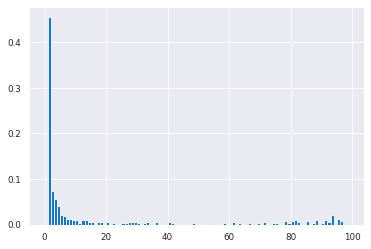

In [ ]:
counts_table.groupby(by='barcode').size().hist(bins=range(0,100), density=True)

In [ ]:
overlaps = counts_table.drop(['forward_primer','reverse_primer','sample'],axis='columns') \
    .groupby(by='barcode') \
    .count() \
    .sort_values(by=['count'], ascending=False)
overlaps[(overlaps['count'] < 5) & (overlaps['count'] > 1)]

,count
barcode,
GTCAGTCTGTGAGAGTGTGAGAGT,4
GTGACACTGTCTGACAGTCAGTCT,4
GTGAGTGTCAGTCAGTCACACT,4
GACTGTGTCTCTGAGAGACACTGT,4
GAGACACTCAGTGACTCAGACTGT,4
...,...
GAGACTGTGTCTCTCTGTGTGTCA,2
CTGTCTGTCAGTGAGTGTGTGACT,2
GACAGACTCAGTCAGTCTGACTCT,2


In [ ]:
counts_and_overlaps = counts_table.set_index('barcode').join(overlaps, how='inner', lsuffix='_reads', rsuffix='_overlaps')
counts_and_overlaps

,forward_primer,reverse_primer,sample,count_reads,count_overlaps
barcode,,,,,
CACACACACTCACAGTCTCAGTGT,oVK025,oVK041,1945,1,9
CACACACACTCACAGTCTCAGTGT,oVK025,oVK043,1947,1,9
CACACACACTCACAGTCTCAGTGT,oVK032,oVK038,1966,1,9
CACACACACTCACAGTCTCAGTGT,oVK032,oVK039,1967,1,9
CACACACACTCACAGTCTCAGTGT,oVK035,oVK043,2024,1,9
...,...,...,...,...,...
GTGTGTGTGTGTGACACTCTCTCA,oVK035,oVK047,2029,1,4
GTGTGTGTGTGTGACACTCTCTCA,oVK036,oVK042,1999,1,4
GTGTGTGTGTGTGAGTCTCAGT,oVK036,oVK038,1995,2,1


In [ ]:
bc1 = counts_table['barcode'].iloc[0]
bc1

'GTGACACTGAGTCTGAGACAGTCT'

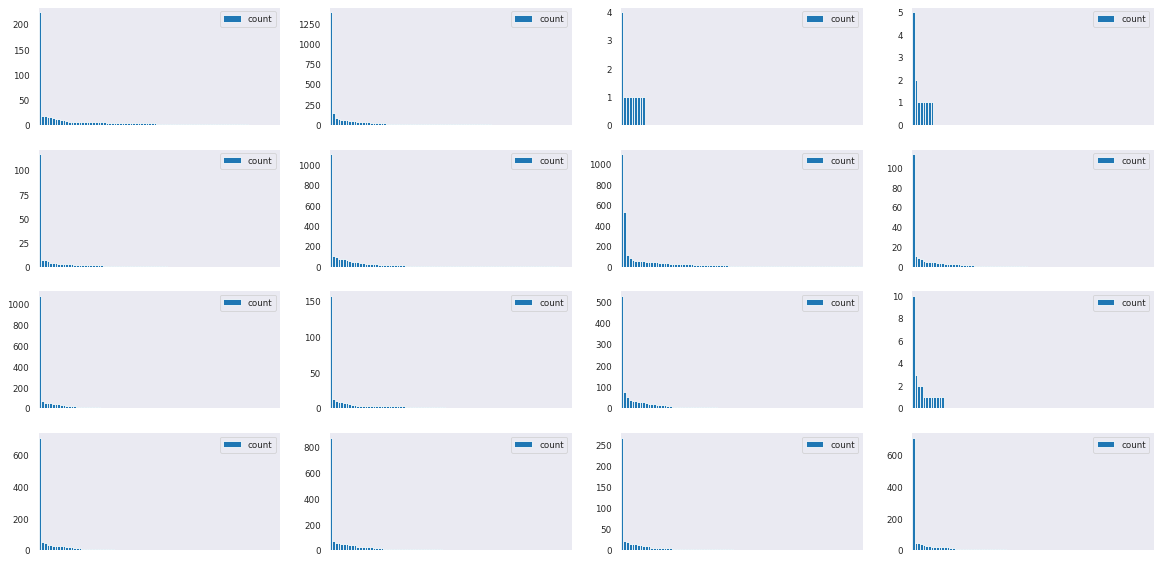

In [ ]:
h, w = (4,4)
barcode_list = list( counts_table['barcode'].sample(n=h*w) )
# print(barcode_list)
fig, axs = plt.subplots(h, w, figsize=(20,10), sharex=True)

for ax, bc in zip([ax for subaxs in axs for ax in subaxs], barcode_list):
    counts_table[counts_table['barcode'] == bc] \
        .sort_values(by='count', ascending=False) \
        .plot \
        .bar(
            ax=ax,
            xticks=[], 
            width=1
        )
plt.show()

In [ ]:
counts_table.groupby('barcode').head()

,forward_primer,reverse_primer,sample,barcode,count
99,oVK025,oVK026,1941,GTGACACTGAGTCTGAGACAGTCT,1108
70,oVK025,oVK026,1941,GAGAGAGAGTGTGAGAGACAGTGA,954
25,oVK025,oVK026,1941,CAGTGTGACTCTGTCAGTGAGAGA,90
113,oVK025,oVK026,1941,GTGTCTGACACTCAGTCTGAGAGT,89
130,oVK025,oVK026,1941,GTGTGTGTGTGAGTGTGTGAGTGT,70
...,...,...,...,...,...
10164,oVK037,oVK048,,GAGTGACTGTGACAGTCTCACACA,1
10172,oVK037,oVK048,,GAGTGTGTGTGACAGTGTGACTCA,1
10185,oVK037,oVK048,,GTCTGACTGAGACACTGTGACACA,1
10194,oVK037,oVK048,,GTGAGTGACTGAGACTGTGACTGT,1


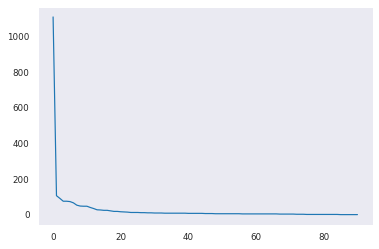

In [ ]:
counts_table[ counts_table['barcode'] == bc1 ]['count'] \
    .sort_values(ascending=False) \
    .reset_index() \
    .plot \
    .line(
        y='count',
        legend=False)

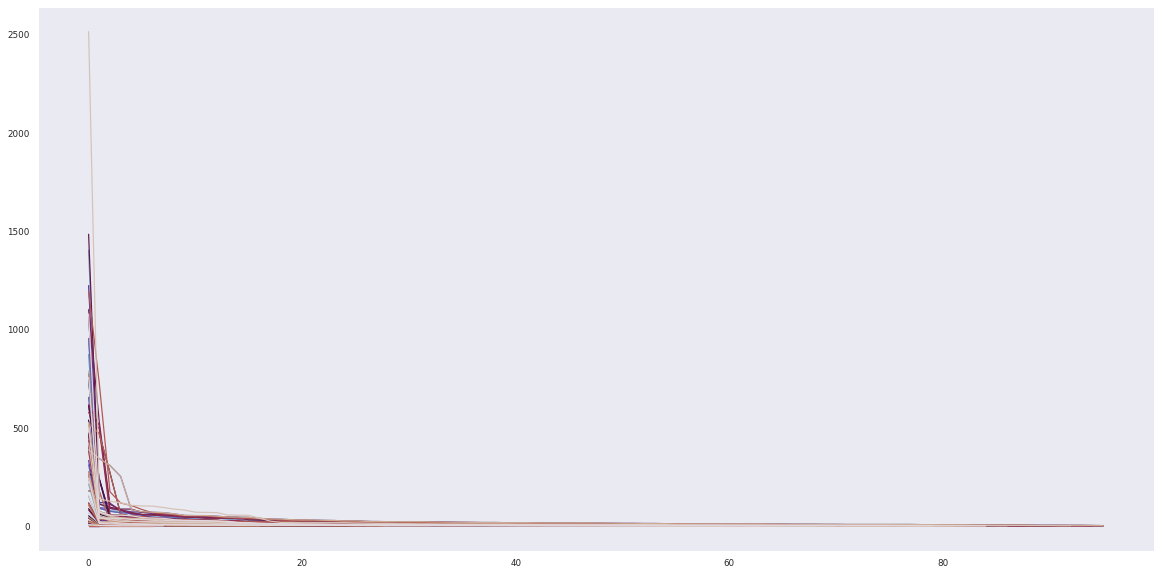

In [ ]:
N = 100

barcode_list = list( counts_table['barcode'].sample(n=N) )
fig, ax = plt.subplots(figsize=(20,10), sharex=True)

colors = plt.cm.twilight(np.linspace(0,1,N))
for bc, c in zip(barcode_list, colors):
    # print(f'barcode: {bc}\tcolor: {c}')
    counts_table[ counts_table['barcode'] == bc ]['count'] \
        .sort_values(ascending=False) \
        .reset_index() \
        .plot \
        .line(
            ax=ax,
            y='count',
            color=tuple(c),
            legend=False)

ValueError: ignored

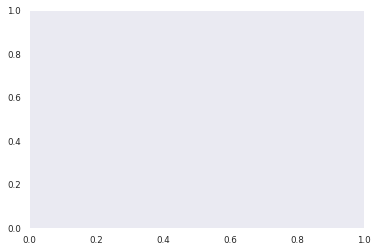

In [ ]:
# barcode_list = list( counts_table['barcode'].sample(n=10) )

fig, ax = plt.subplots()
for label, grp in counts_table.groupby('barcode').head():
    # print(grp)
    grp.sort_values(by='count', ascending=False).plot(ax=ax)
    # grp.plot(x = grp.index, y = 'count', ax = ax, label = label)

In [ ]:
counts_and_overlaps[counts_and_overlaps['count_overlap'] == 2]

KeyError: ignored

In [ ]:
counts_and_overlaps[counts_and_overlaps['sample'] == 'water'].sort_values(by='count_overlaps', ascending=False)

,forward_primer,reverse_primer,sample,count_reads,count_overlaps
barcode,,,,,
GTCAGAGTCTGACTGTGTCAGAGA,oVK033,oVK048,water,10,96
CTGACTGTCTCACTCTGAGAGAGA,oVK033,oVK048,water,13,96
CAGTGTGACTCTGTCAGTGAGAGA,oVK033,oVK048,water,18,96
GTGTGTGTGTCAGTGACTGACAGT,oVK033,oVK048,water,31,96
GAGTGAGTGTGAGACTGAGTCAGT,oVK033,oVK048,water,4,95
...,...,...,...,...,...
GAGTGTCAGTGTGAGTGAGAGTCT,oVK033,oVK048,water,1,8
CTGTCACACTCACAGTGAGACAGA,oVK033,oVK048,water,1,4
GACTCTGTGAGACTCAGTGACTGA,oVK033,oVK048,water,1,4


KeyError: ignored

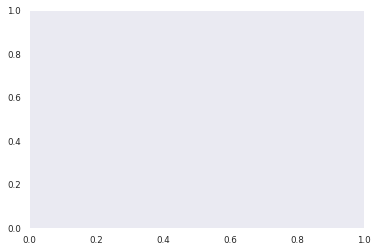

In [ ]:
counts_and_overlaps.drop(['forward_primer','reverse_primer','sample'],axis='columns') \
    .groupby(by='barcode') \
    .max() \
    .plot(x='count_overlap', y='count_reads', kind='scatter')

In [ ]:
# https://matplotlib.org/stable/gallery/specialty_plots/hinton_demo.html

def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log2(np.abs(matrix).max()))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

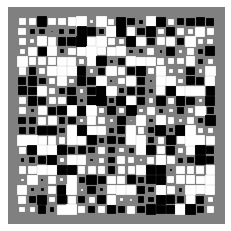

In [ ]:
np.random.seed(19680801)
hinton(np.random.rand(20, 20) - 0.5)
plt.show()

## Filter for Clones with 1 or 2 Dominant Barcodes

In [ ]:
z = y.reset_index()
sns.set_style()
sns.set_style("dark")
sns.set_context("paper")
g2 = sns.FacetGrid(z, row="forward_primer", col="reverse_primer", height=2.5, aspect=1 ,margin_titles=True)
g2.map_dataframe(sns.barplot,x="running_percent",y="barcode", orient='h')
g2.set_yticklabels(None)
g2.set_xticklabels(None)
g2.set_titles(col_template="{col_name}", row_template="{row_name}", size=18)

for ax in g2.axes.flat:
    ax.axvline(x=0.5, color='r', linestyle='-')

plt.subplots_adjust(top=0.9)
g2.fig.suptitle(experiment, fontsize=24)

NameError: ignored

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [ ]:
samples_list = [s for sublist in data for s in sublist if s != '']
samples_list

['1941',
 '1942',
 '1943',
 '1944',
 '1945',
 '1946',
 '1947',
 '1948',
 '1949',
 '1950',
 '1951',
 '1952',
 '1953',
 '1954',
 '1955',
 '1956',
 '1957',
 '1958',
 '1959',
 '1960',
 '1961',
 '1962',
 '1963',
 '1964',
 '1965',
 '1966',
 '1967',
 '1968',
 '1969',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 'water',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2022',
 '2023',
 '2024',
 '2025',
 '2027',
 '2028',
 '2029',
 '2030',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 'Hct 116']

In [ ]:
sample_N_table = {}

@interact
def pick_N_for_sample(sample=samples_list, barcode_count=[1,2,3,4,'many']):
    sample_N_table[sample] = barcode_count
    return counts_table[counts_table['sample']==sample].sort_values("count", ascending=False).head(25).plot.bar(
        y="count", 
        xticks=[], 
        figsize=(10,5), 
        linewidth=1,
        width=1)

interactive(children=(Dropdown(description='sample', options=('1941', '1942', '1943', '1944', '1945', '1946', …

In [ ]:
sample_N_table

{'1941': 1}